<a href="https://colab.research.google.com/github/MananShukla7/SkimLit/blob/main/skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project : SkimLit📝🔥

`Short for Skimming Literature`

The purpose of this notebook is to build a NLP model to make reading medical abstracts
a lot easier

The Dataset that we are using is PubMed 200k RCT and the paper we are replicating is :
https://arxiv.org/abs/1710.06071



##Confirming access to GPU

In [1]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


##Getting Data

Downloading the dataset from the paper's author: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.77 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
#Check what filer are in the PubMed 20k dataset
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
#Start our experiments by exploring and experimenting on 20k dataset!
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
#Check all of the filename of its directory
import os
filenames=[data_dir+"/"+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##Data Preprocessing

Now we've got some text data, now we have to explore it throughly.

To do that we need to visualise it first.

In [6]:
#Reading the files with python

def get_lines(filename):
  """
  Reads the filename (a text filename) and returns all of the lines of the text file
  as a list.

  Args:
  filname: a string containing the target filepath

  Returns:
  A list of string with one string per line from the input text line
  """
  f=open(filename,"r")
  return f.readlines()



In [7]:
# Let's read into the training lines
train_dir=filenames[1]
train_lines=get_lines(train_dir)
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

###Data Structuring

Representing this data into dictionaries as it is easily manipulated.

A sample structure would look like:

```[{'line_number' : 0,
   'target' : 'BACKGROUND',
   'text' : 'Emotional eating is associated with overeating and the development of obesity .\n',
   'total_lines' : 11, 
   ...
   }]```

In [9]:
# def preprocess_text_with_line_num(filename):
#   types=["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSION"]
#   list1=[]
#   txtData=get_lines(filename)
#   linecount=0
#   for txt in txtData:
   
#     if txt.startswith("###"):
#         linecount=0
#         start_index=txtData.index(txt)
#         end_index=txtData.index("\n",start_index)
#         total_lines=end_index-start_index
#         # dict.update()
    
#     elif txt.isspace():

#       continue

#     else:

#       # for typ in types:
#       #   if typ in txt:
#       #     target=typ
#       target="abc"


#       start=txt.find("\t")
#       end=txt.find(".\n")
#       text=txt[start+1:end+1]
            
      
#       data={}
#       data["line_number"]=linecount
#       data["target"]=target
#       data["text"]=text
#       data["total_line"]=total_lines
#       # print(target.dtype)
#       list1.append(data)
#       linecount+=1
#       # print(f"[line_number:{linecount},\ntarget:{target},\ntext:{text},\ntotal_line:{total_lines}]\n\n")
#   return list1
  




  
    
    

In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [11]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [12]:
%%time
train_samples=preprocess_text_with_line_numbers(filenames[1])
val_samples=preprocess_text_with_line_numbers(filenames[0])
test_samples=preprocess_text_with_line_numbers(filenames[2])


CPU times: user 666 ms, sys: 146 ms, total: 811 ms
Wall time: 1.39 s


In [13]:
str1="###35279E"
x="###" in str1
x

True

In [14]:
l1=["BAKCGROUND","obj\n","\n"]
str2="BAKCGROUND \n ribdiuabda oddnaoid.\n"
for i in l1:
  print(i)
  if i in str2:
    x=i
s=str2.find("KC")
x,s

BAKCGROUND
obj





('\n', 2)

In [15]:
str2[0:2]

'BA'

In [16]:
l1.index("\n")

2

In [17]:
td="""Recreate the above func of greater efficiency """

##Data Analysis
Now that our data is in the format of dictionaries ,we can turn it into the df to
visualize it much better

In [18]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [19]:
#DIstribution of labels in training labels
distrib=train_df.target.value_counts()
distrib


METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<BarContainer object of 5 artists>

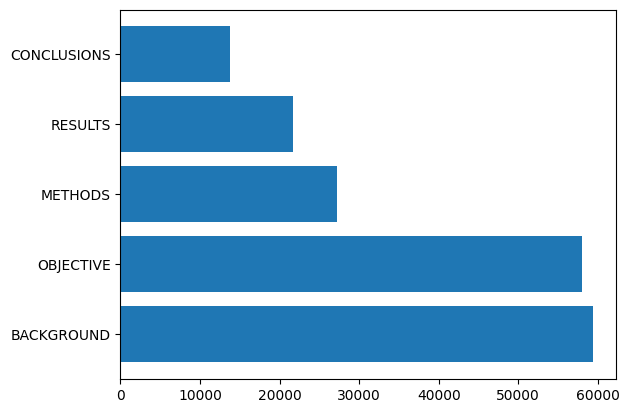

In [20]:
import matplotlib.pyplot as plt

plt.barh(val_df.target.unique(),distrib)

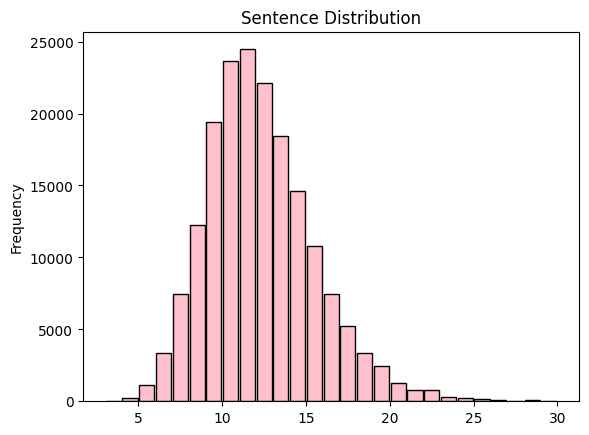

In [21]:
#Check length of different lines

# plt.bar(range(0,train_df.total_lines.value_counts().max()),train_df.total_lines.value_counts())
train_df.total_lines.plot(kind="hist",bins=27,rwidth=0.9,edgecolor="black",color="pink",xlabel="Number of sentences per abstract",title="Sentence Distribution");

In [22]:
(train_df.total_lines.value_counts())

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

###Get the list of the sentences


In [23]:
#Convert abstract text into lists
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()
len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [54]:
train_labels=train_df["target"].tolist()
val_labels=val_df["target"].tolist()
test_labels=test_df["target"].tolist()
len(train_labels),len(val_labels),len(test_labels)

(180040, 30212, 30135)

In [55]:
#View the first 10 lines of the training sentences
train_sentences[:10],train_labels[:10]

(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
  'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
  'there was a

##Making the numeric labels(for ml model)

###One hot encoder

In [25]:
# !pip install category_encoders -q
# import category_encoders as ce
# one_hot_encoded_lables=ce.OneHotEncoder(val_df.target.unique())


Using the get_dummies for now...

In [26]:
%%time
train_encoded_onehot=pd.get_dummies(train_df.target).to_numpy()
val_encoded_onehot=pd.get_dummies(val_df.target).to_numpy()
test_encoded_onehot=pd.get_dummies(test_df.target).to_numpy()

CPU times: user 39.4 ms, sys: 3.06 ms, total: 42.4 ms
Wall time: 58.4 ms


In [27]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False)#tf doesnt support sparse matrix


In [28]:
%%time
train_one_hot=encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
train_one_hot

CPU times: user 50.3 ms, sys: 12.9 ms, total: 63.2 ms
Wall time: 73.9 ms


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#####**Result**: get_dummies is a bit faster then one_hot(sklearn) [will see difference in the 200k dataset]

In [29]:
train_df.target[:5]

0    OBJECTIVE
1      METHODS
2      METHODS
3      METHODS
4      METHODS
Name: target, dtype: object

###Label encode labels



####Manual labelling

In [30]:
#Creating a Dictionary of target labels
target_labels={label:target for label,target in enumerate(val_df.target.unique())}
target_labels

{0: 'BACKGROUND', 1: 'OBJECTIVE', 2: 'METHODS', 3: 'RESULTS', 4: 'CONCLUSIONS'}

In [31]:
#get class names
class_names=val_df.target.unique()
class_names

array(['BACKGROUND', 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS'],
      dtype=object)

In [32]:
test=train_df.replace(train_df.target.unique(),range(0,len(train_df.target.unique())))
test[:5]

,target,text,line_number,total_lines
0,0,to investigate the efficacy of @ weeks of dail...,0,11
1,1,a total of @ patients with primary knee oa wer...,1,11
2,1,outcome measures included pain reduction and i...,2,11
3,1,pain was assessed using the visual analog pain...,3,11
4,1,secondary outcome measures included the wester...,4,11


####Using Sklearn here

In [75]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

#check what the training label look like

train_labels_encoded[:5],train_labels_encoded.shape

(array([3, 2, 2, 2, 2]), (180040,))

In [76]:
class_names[train_labels_encoded[:5]]

array(['RESULTS', 'METHODS', 'METHODS', 'METHODS', 'METHODS'],
      dtype=object)

###Model 0(Bayes Classification): The baseline

In [77]:
#importing libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [78]:
idf_vectorizer=TfidfVectorizer()
vectorized_sentences=idf_vectorizer.fit_transform(train_sentences)
vectorized_val_sentences=idf_vectorizer.transform(val_sentences)

In [79]:
len(train_sentences),vectorized_sentences.data

(180040,
 array([0.22142104, 0.21325032, 0.18343203, ..., 0.11908607, 0.17476079,
        0.07701092]))

In [80]:
vectorized_val_sentences.shape,vectorized_sentences.shape

((30212, 45871), (180040, 45871))

In [81]:
nb_classifier=MultinomialNB()
nb_classifier.fit(vectorized_sentences,train_labels_encoded)

MultinomialNB()

In [82]:
nb_classifier.score(vectorized_val_sentences,val_labels_encoded)

0.7218323844829869

(180040, 45871)